# Polygons - Buildings of Liverpool
https://geoportal.statistics.gov.uk<br>
https://osdatahub.os.uk/

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.affinity import translate, scale
import contextily as cx

In [2]:
# Downloaded files from OS and ONS

zoom="C:\dataGIS\OS\Zoomstack\OS_Open_Zoomstack.gpkg"
shpLA="C:\dataGIS\ONS\LocalAuthorities\Local_Authority_Districts_(December_2020)_UK_BFC.shp"
shpWD="C:\dataGIS\ONS\Wards\Wards_(May_2021)_UK_BFC.shp"

s_title1='The Buildings of Liverpool'
s_title2='The enlarged boundaries of 78,966 buildings in each electoral ward and superimposed on the centroid'
s_day='Brian Price #30DayMapChallenge 2021 Day 3 Polygons'

s_code='Created using Python/Jupyter Notebook at github.com/bpmapper/bp21map30'
s_data='Data from ONS and OS Zoomstack. Contains OS data © Crown copyright and database right 2021'
s_ons='Office for National Statistics licensed under the Open Government Licence v.3.0'
s_tiles='Map tiles by Stamen Design under CCBY3.0. Data by OpenStreetMap under ODbL'

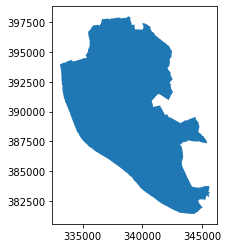

In [3]:
# Get LA shape

gdfLA=gpd.read_file(shpLA)
gdfLA=gdfLA[gdfLA.LAD20NM=='Liverpool'].copy()
gdfLA.plot()

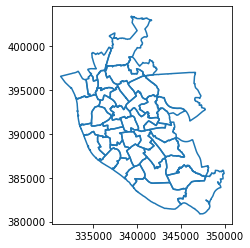

In [4]:
#  Get wards within LA

gdfW=gpd.read_file(shpWD, mask=gdfLA)
gdfW.boundary.plot()

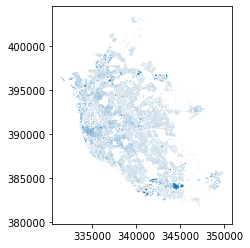

In [5]:
# Get buildings

gdfB=gpd.read_file(zoom,layer='local_buildings', mask=gdfW)
gdfB.plot()

In [6]:
# Most buildings by ward

gdfWB=gpd.sjoin(gdfB,gdfW,predicate='within')
gdfWB.WD21NM.value_counts()[:3]

Woolton          2774
Croxteth         2684
Speke-Garston    2547
Name: WD21NM, dtype: int64

In [7]:
# Function to translate polygon to centroid of given geodataframe and scale up 4x

def CentreShape(pol, gdf): 
    dx = -pol.centroid.x + gdf.centroid.x 
    dy = -pol.centroid.y + gdf.centroid.y
    return scale(translate(pol.boundary, dx, dy),4,4)

In [8]:
# Convert crs to WGS84

gdfWB=gdfWB.to_crs('epsg:3857')
gdfW=gdfW.to_crs('epsg:3857')

In [9]:
# Loop through wards and translate all buildings to ward centre

gdf={}
for wd in gdfWB.WD21NM.drop_duplicates():
    cent=gdfW.centroid
    gdfX=gdfWB[gdfWB.WD21NM==wd].copy()
    gdfX['geometry']=gdfX.geometry.apply(CentreShape, gdf=gdfW[gdfW.WD21NM==wd])
    gdf[wd]=gdfX.copy()

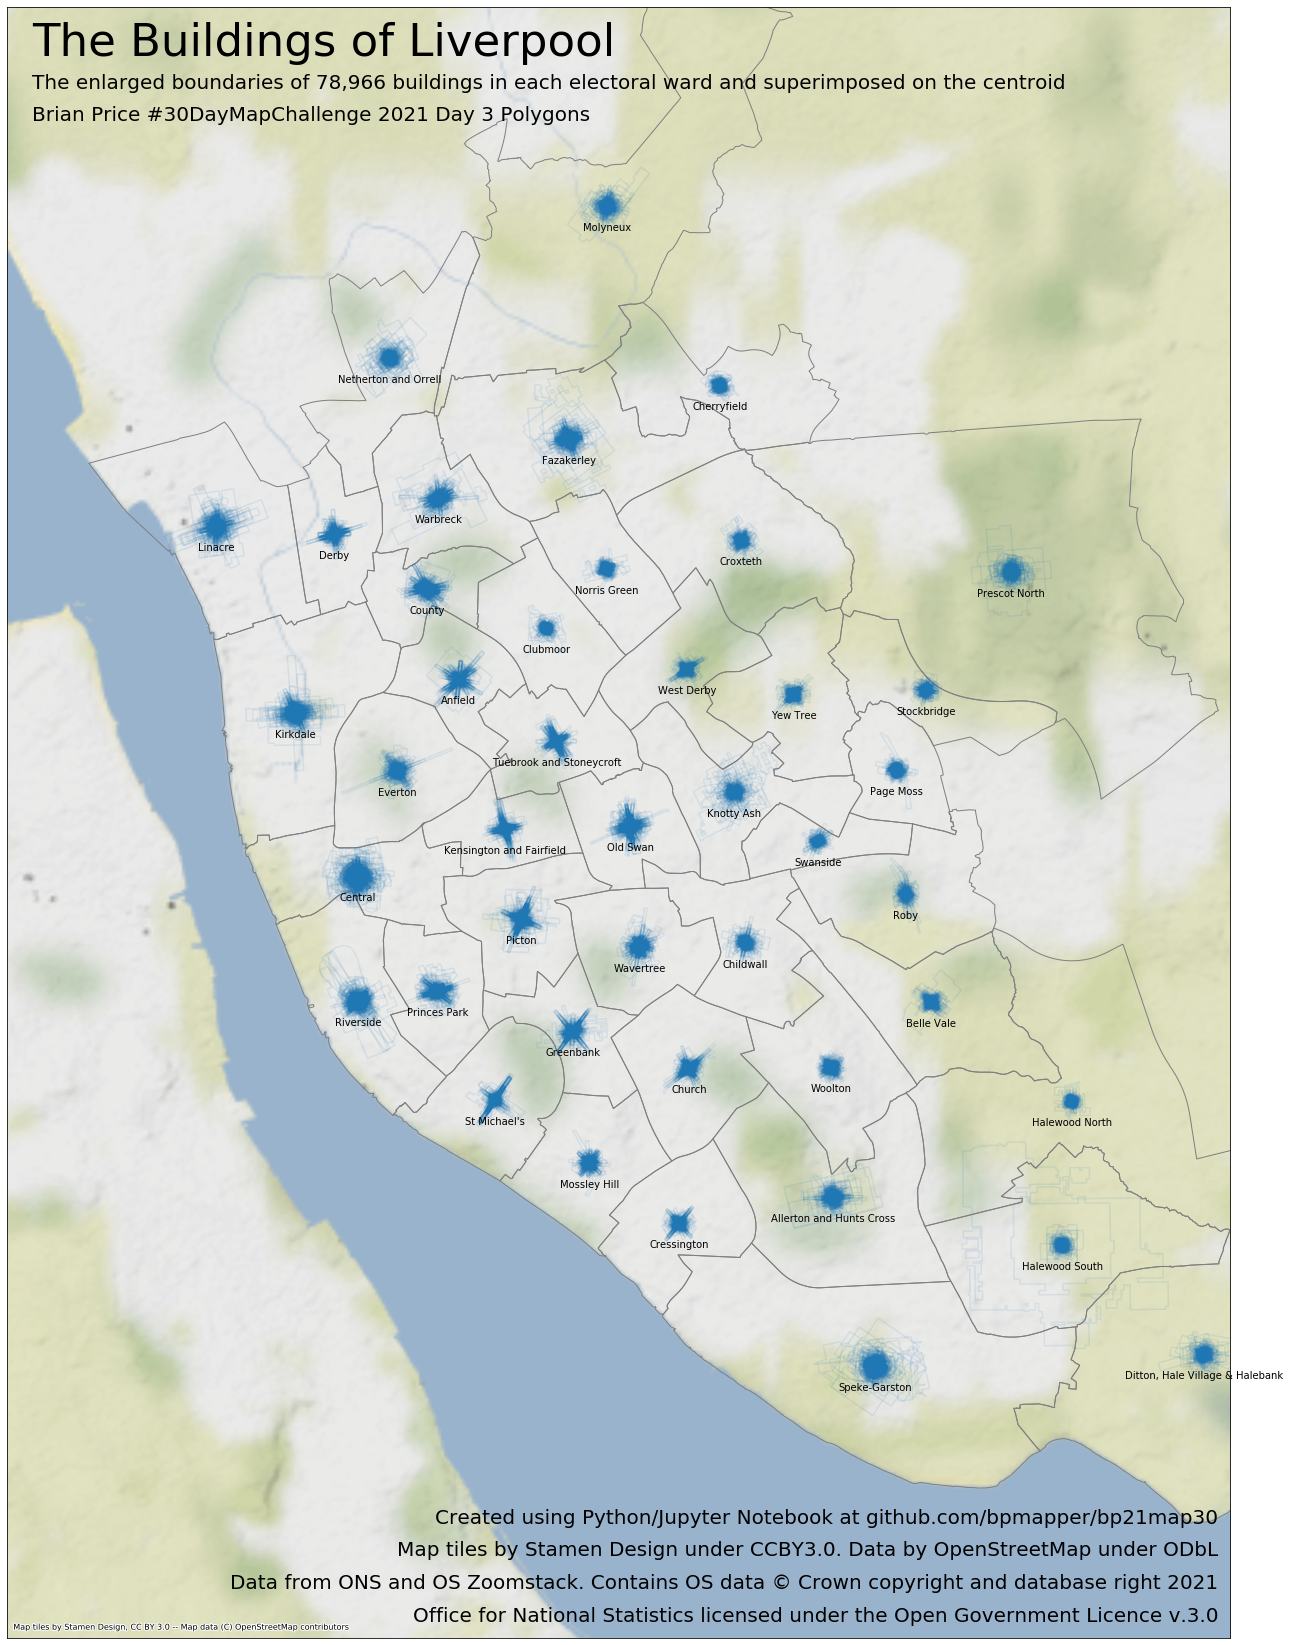

In [11]:
# Plot

fig, ax=plt.subplots(figsize=(25,30))
gdfW.boundary.plot(ax=ax, linewidth=1, color='grey')
for wd in gdfWB.WD21NM.drop_duplicates():
    gdf[wd].plot(ax=ax, alpha=.1)
    
    cent=gdfW[gdfW.WD21NM==wd].centroid
    ax.text(cent.x,cent.y-600,wd,horizontalalignment='center')
    
cx.add_basemap(ax=ax, source=cx.providers.Stamen.TerrainBackground, zoom=11)

ax.set_ylim([7040000, 7080000])
ax.set_xlim([-340000, -310000])
plt.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)

ax.text(.02,.97,s_title1,transform=ax.transAxes, fontsize=45).set_color('black')       
ax.text(.02,.95,s_title2,transform=ax.transAxes, fontsize=20).set_color('black')       
ax.text(.02,.93,s_day,transform=ax.transAxes, fontsize=20).set_color('black')

ax.text(.99,.07,s_code,transform=ax.transAxes, fontsize=20, horizontalalignment='right').set_color('black')       
ax.text(.99,.05,s_tiles,transform=ax.transAxes, fontsize=20, horizontalalignment='right').set_color('black')       
ax.text(.99,.03,s_data,transform=ax.transAxes, fontsize=20, horizontalalignment='right').set_color('black')       
ax.text(.99,.01, s_ons,transform=ax.transAxes, fontsize=20, horizontalalignment='right').set_color('black')

fig.savefig('Day03_Polygons_Liverpool.png')
plt.show()